In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sspspace

# Random Encoding

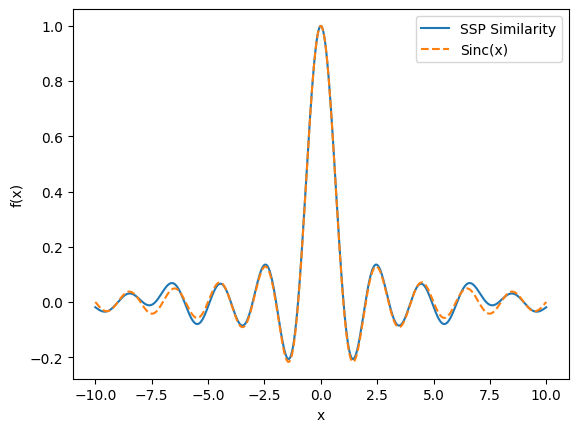

In [3]:
xs = np.linspace(-10,10,1000).reshape((-1,1))
rand_encoder = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=1024*2, length_scale=1/np.pi)

query_xs_ssp = rand_encoder.encode(xs)
origin_ssp = rand_encoder.encode([[0]])

sims = query_xs_ssp | origin_ssp
true_sims = np.sinc(xs)

error = np.mean(np.power(sims-true_sims, 2))

assert error < 0.01, f'Expected error of 0.01, got {error}'
plt.plot(xs, sims, label='SSP Similarity')
plt.plot(xs, true_sims, ls='--', label='Sinc(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

([], [])

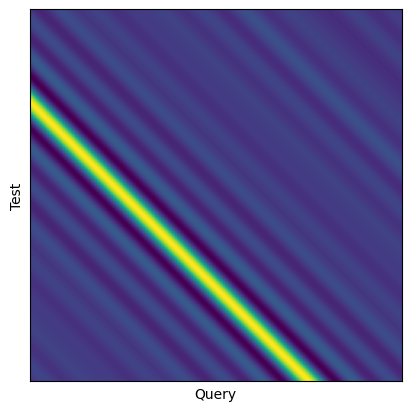

In [4]:
test_xs_ssp = rand_encoder.encode(np.linspace(-5,15,1000).reshape((-1,1)))
sims_2d = query_xs_ssp | test_xs_ssp
plt.matshow(sims_2d)
plt.xlabel('Query')
plt.ylabel('Test')
plt.xticks([])
plt.yticks([])

In [5]:
a = np.array([[0]])
b = np.array([[5]])

a_ssp = rand_encoder.encode(a)
b_ssp = rand_encoder.encode(b)

print(test_xs_ssp[:10] | b_ssp)
print(np.sinc(np.pi * 5))

[[-0.01910042]
 [-0.02034196]
 [-0.02156464]
 [-0.02276366]
 [-0.02393422]
 [-0.02507153]
 [-0.02617084]
 [-0.02722744]
 [-0.02823672]
 [-0.02919414]]
-0.016091030896682075


Note: use @ sign for similarity?

# Cyclic SSPs

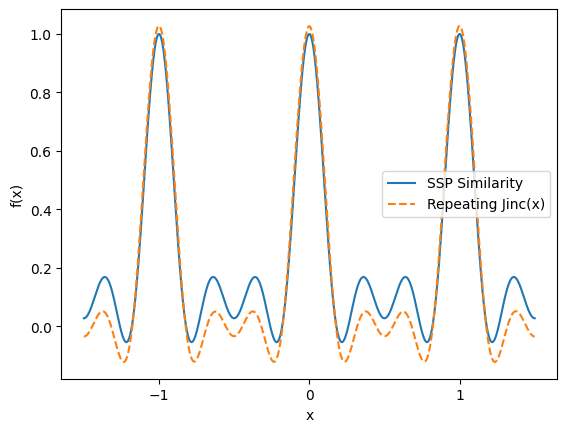

In [6]:
xs = np.linspace(-1.5,1.5,1000).reshape((-1,1))
cyc_encoder = sspspace.CyclicSSPSpace(ssp_dim=255, domain_dim=1, band_scale=0.3, period=1, kernel="jinc")

query_xs_ssp = cyc_encoder.encode(xs)
origin_ssp = cyc_encoder.encode([[0]])

from scipy.special import jv
sims = query_xs_ssp | origin_ssp
Q = (2 * np.round(1/0.3) + 1)

true_sims = 2 * jv(1, 2 * np.pi * xs / 0.3) / (2 * np.pi * xs / 0.3)
for i in np.arange(1,10):
    true_sims += 2 * jv(1, 2 * np.pi * (xs + i) / 0.3) / (2 * np.pi * (xs + i) / 0.3)
    true_sims += 2 * jv(1, 2 * np.pi * (xs - i) / 0.3) / (2 * np.pi * (xs - i) / 0.3)
error = np.mean(np.power(sims-true_sims, 2))

# assert error < 0.01, f'Expected error of 0.01, got {error}'
plt.plot(xs, sims, label='SSP Similarity')
plt.plot(xs, true_sims, ls='--', label='Repeating Jinc(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xticks([-1, 0, 1])
plt.legend()


# Hexagonal SSPs

Note: check Nengo tools for even sampling of rotations in domain dim > 3

Note: add functionality to add grid sampling, code to return samples as ssps.

Note: add similarity plots of ssps over domain. 

Note: add similarities as probabilities

[[ 0.          0.        ]
 [-0.83255461 -0.83255461]
 [ 1.13729075 -0.30473614]
 [-0.30473614  1.13729075]
 [ 0.30473614 -1.13729075]
 [-1.13729075  0.30473614]
 [ 0.83255461  0.83255461]]


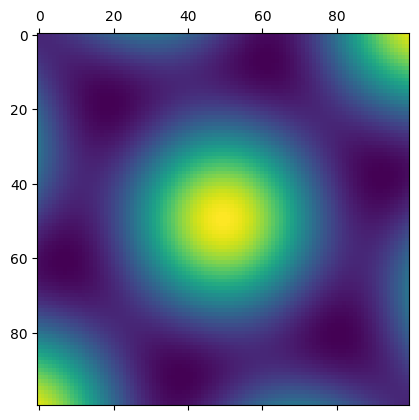

In [7]:
xs = np.linspace(-2,2,100).reshape((-1,1))
ys = np.linspace(-2,2,100).reshape((-1,1))

X, Y = np.meshgrid(xs, ys)
xys = np.vstack((X.flatten(), Y.flatten())).T

hex_encoder = sspspace.HexagonalSSPSpace(domain_dim=2, n_rotates=1, n_scales=1, kernel='gaussian')
print(hex_encoder.phase_matrix)
hex_encoder.update_lengthscale(0.5)

query_xys_ssp = hex_encoder.encode(xys)
origin_ssp = hex_encoder.encode([[0,0]])

sims = query_xys_ssp | origin_ssp
square_sims = sims.reshape((ys.shape[0], xs.shape[0]))

plt.matshow(square_sims)

In [141]:
print(X[0,:], Y[0,:])

[-15.         -14.6969697  -14.39393939 -14.09090909 -13.78787879
 -13.48484848 -13.18181818 -12.87878788 -12.57575758 -12.27272727
 -11.96969697 -11.66666667 -11.36363636 -11.06060606 -10.75757576
 -10.45454545 -10.15151515  -9.84848485  -9.54545455  -9.24242424
  -8.93939394  -8.63636364  -8.33333333  -8.03030303  -7.72727273
  -7.42424242  -7.12121212  -6.81818182  -6.51515152  -6.21212121
  -5.90909091  -5.60606061  -5.3030303   -5.          -4.6969697
  -4.39393939  -4.09090909  -3.78787879  -3.48484848  -3.18181818
  -2.87878788  -2.57575758  -2.27272727  -1.96969697  -1.66666667
  -1.36363636  -1.06060606  -0.75757576  -0.45454545  -0.15151515
   0.15151515   0.45454545   0.75757576   1.06060606   1.36363636
   1.66666667   1.96969697   2.27272727   2.57575758   2.87878788
   3.18181818   3.48484848   3.78787879   4.09090909   4.39393939
   4.6969697    5.           5.3030303    5.60606061   5.90909091
   6.21212121   6.51515152   6.81818182   7.12121212   7.42424242
   7.727272

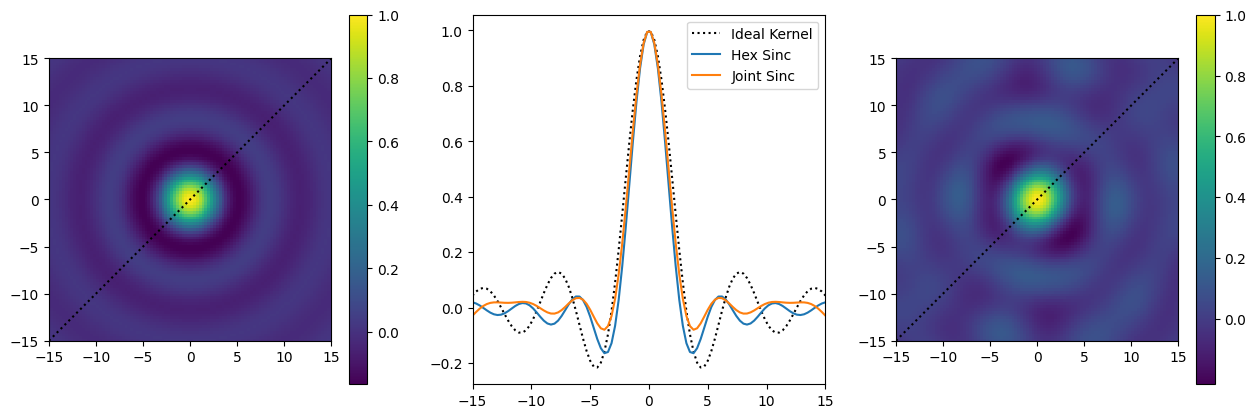

In [144]:
h = 15
xs = np.linspace(-h,h,100).reshape((-1,1))
ys = np.linspace(-h,h,100).reshape((-1,1))

X, Y = np.meshgrid(xs, ys)
xys = np.vstack((X.flatten(), Y.flatten())).T

n_rotates = 7
n_scales = 15
hex_encoder = sspspace.HexagonalSSPSpace(domain_dim=2, n_rotates=n_rotates, n_scales=n_scales, kernel='sinc')
joint_encoder = sspspace.JointSSPSpace(domain_dim=2, ssp_dim=6 * n_rotates * n_scales + 1, kernel="sinc")

f, axs = plt.subplot_mosaic([["A", "B", "C"]])
f.subplots_adjust(right=2)
axs["B"].plot(X[100//2,:], np.sinc(X[100//2,:] / np.pi), 'k:', label="Ideal Kernel")
for space, ax, label in zip([hex_encoder, joint_encoder], [axs["A"], axs["C"]], ["Hex Sinc", "Joint Sinc"]):
    query_xys_ssp = space.encode(xys)
    origin_ssp = space.encode([[0,0]])

    sims = query_xys_ssp | origin_ssp
    square_sims = sims.reshape((ys.shape[0], xs.shape[0]))

    axs["B"].plot(X[0,:], [square_sims[i,i] for i in range(100)], label=label)

    im = ax.pcolormesh(X, Y, sims.reshape(X.shape), vmin=sims.min() if sims.min() < 0 else 0, vmax=sims.max() if sims.max() > 1 else 1)
    ax.plot(X[0,:], X[0,:], 'k:')
    ax.set_aspect('equal', 'box')

    ax.set_xlim(-h,h)
    ax.set_ylim(-h,h)
    cbar = ax.figure.colorbar(im, ax=ax, ticks=[0,0.2,0.4, 0.6, 0.8, 1.0])

axs["B"].set_xlim(-h,h)
axs["B"].legend()
# ax.plot(phases_hex[:,0],phases_hex[:,1],'r*')

# plt.matshow(square_sims)


In [133]:
print(X)

[[-15.         -14.6969697  -14.39393939 ...  14.39393939  14.6969697
   15.        ]
 [-15.         -14.6969697  -14.39393939 ...  14.39393939  14.6969697
   15.        ]
 [-15.         -14.6969697  -14.39393939 ...  14.39393939  14.6969697
   15.        ]
 ...
 [-15.         -14.6969697  -14.39393939 ...  14.39393939  14.6969697
   15.        ]
 [-15.         -14.6969697  -14.39393939 ...  14.39393939  14.6969697
   15.        ]
 [-15.         -14.6969697  -14.39393939 ...  14.39393939  14.6969697
   15.        ]]


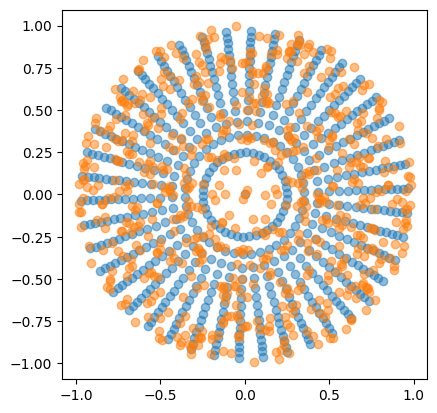

In [131]:
plt.scatter(hex_encoder.phase_matrix[:,0], hex_encoder.phase_matrix[:,1], alpha=0.5)
plt.scatter(joint_encoder.phase_matrix[:,0], joint_encoder.phase_matrix[:,1], alpha=0.5)
plt.gca().set_aspect("equal")

# Bundling

Note: make bundling consistent with what numpy does (change assert to only check number of ssp features)


In __init__ with class <class 'sspspace.ssp.SSP'>
In __init__ with class <class 'sspspace.ssp.SSP'>
In __init__ with class <class 'sspspace.ssp.SSP'>


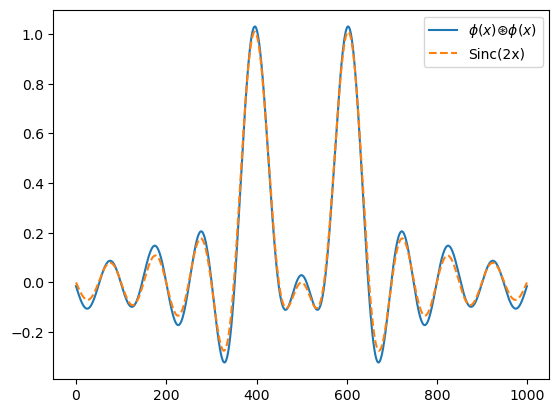

In [30]:
xs = np.linspace(-10,10,1000).reshape((-1,1))
rand_encoder = sspspace.RandomSSPSpace(domain_dim=1,ssp_dim=1024*2)
 
query_xs_ssp = rand_encoder.encode(xs)
origin_ssp = rand_encoder.encode([[-2]]) + rand_encoder.encode([[2]])
 
sims = query_xs_ssp | origin_ssp
true_sims = np.sinc(xs-2) + np.sinc(xs+2)
error = np.mean(np.power(sims-true_sims, 2))

plt.plot(sims, label=r'$\phi(x)\circledast\phi(x)$')
plt.plot(true_sims, ls='--', label='Sinc(2x)')
plt.legend()

# Binding

Assumes we are binding the same number of vectors together, pairwise.

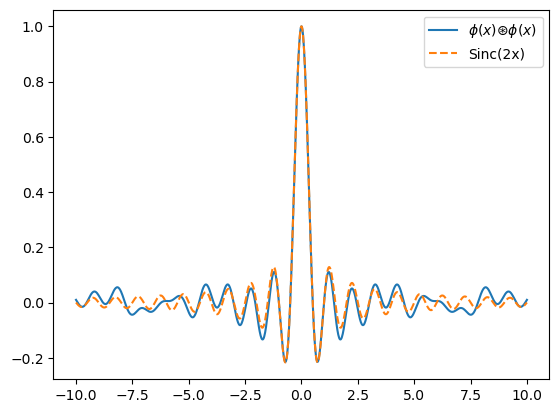

In [11]:
xs = np.linspace(-10,10,1000).reshape((-1,1))
rand_encoder = sspspace.RandomSSPSpace(domain_dim=1,ssp_dim=1024*2)
 
query_xs_ssp = rand_encoder.encode(xs)
origin_ssp = rand_encoder.encode([[0]])
 
bound_self = query_xs_ssp * query_xs_ssp
sims = bound_self | origin_ssp
true_sims = np.sinc(2 * xs)
error = np.mean(np.power(sims-true_sims, 2))

plt.plot(xs, sims, label=r'$\phi(x)\circledast\phi(x)$')
plt.plot(xs, true_sims, ls='--', label='Sinc(2x)')
plt.legend()

# Invert

In __init__ with class <class 'sspspace.ssp.SSP'>


<StemContainer object of 3 artists>

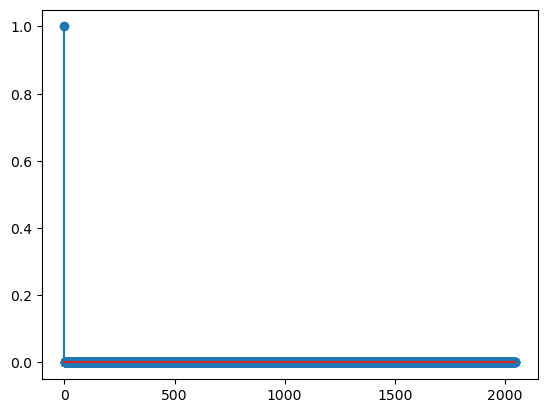

In [25]:
rand_encoder = sspspace.RandomSSPSpace(domain_dim=1,ssp_dim=1024*2)
 
origin_ssp = rand_encoder.encode([[0]])
origin_inv_ssp = ~origin_ssp
 
bound_vec = origin_inv_ssp * origin_ssp

plt.stem(np.arange(bound_vec.shape[1]), bound_vec.T)

# Decode SSPs

In [12]:
bounds = np.array([[-10,10]])
ssp_encoder = sspspace.RandomSSPSpace(domain_dim=1,ssp_dim=128)
ssp_decoder, training_history = sspspace.train_decoder_net(ssp_encoder, bounds, 
                                    n_training_pts=200000, # number of points sample from domain
                                    hidden_units=[8], # list of neurons in dense hidden layers
                                    learning_rate=1e-3, # learning rate for Adam
                                    n_epochs=20, # Max epochs
                                    patience=3, # patience for early stopping
                                    verbose=True # print tensorflow training nonsense.
                                )




2023-03-03 12:48:46.059751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-03 12:48:46.059793: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-03 12:48:50.663494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-03 12:48:50.664008: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-03 12:48:50.664046: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hubel): /proc/driver/nvidia/version does not exist
2023-03-03 12:48:50.748312: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/20
5625/5625 [==============================] - 12s 2ms/step - loss: 0.3236 - val_loss: 2.4724e-04
Epoch 2/20
5625/5625 [==============================] - 10s 2ms/step - loss: 6.8811e-04 - val_loss: 4.2108e-04
Epoch 3/20
5625/5625 [==============================] - 11s 2ms/step - loss: 5.1201e-04 - val_loss: 1.0634e-04
Epoch 4/20
5625/5625 [==============================] - 10s 2ms/step - loss: 4.5880e-04 - val_loss: 4.4394e-05
Epoch 5/20
5625/5625 [==============================] - 10s 2ms/step - loss: 3.8697e-04 - val_loss: 2.1640e-05
Epoch 6/20
5625/5625 [==============================] - 10s 2ms/step - loss: 3.5743e-04 - val_loss: 2.3562e-04
Epoch 7/20
5625/5625 [==============================] - 10s 2ms/step - loss: 3.1025e-04 - val_loss: 1.8466e-04
Epoch 8/20
5625/5625 [==============================] - 10s 2ms/step - loss: 2.6220e-04 - val_loss: 0.0025
Epoch 9/20
5625/5625 [==============================] - 10s 2ms/step - loss: 2.5545e-04 - val_loss: 6.3848e-05
Epoch 10/

In [15]:
xs = np.random.uniform(low=bounds[0,0],high=bounds[0,1], size=(100,1))
enc_ssps = ssp_encoder.encode(xs)

1.2491746920027333e-12 1.1176648388505086e-06
0.01644496029257425 0.04379411085431619


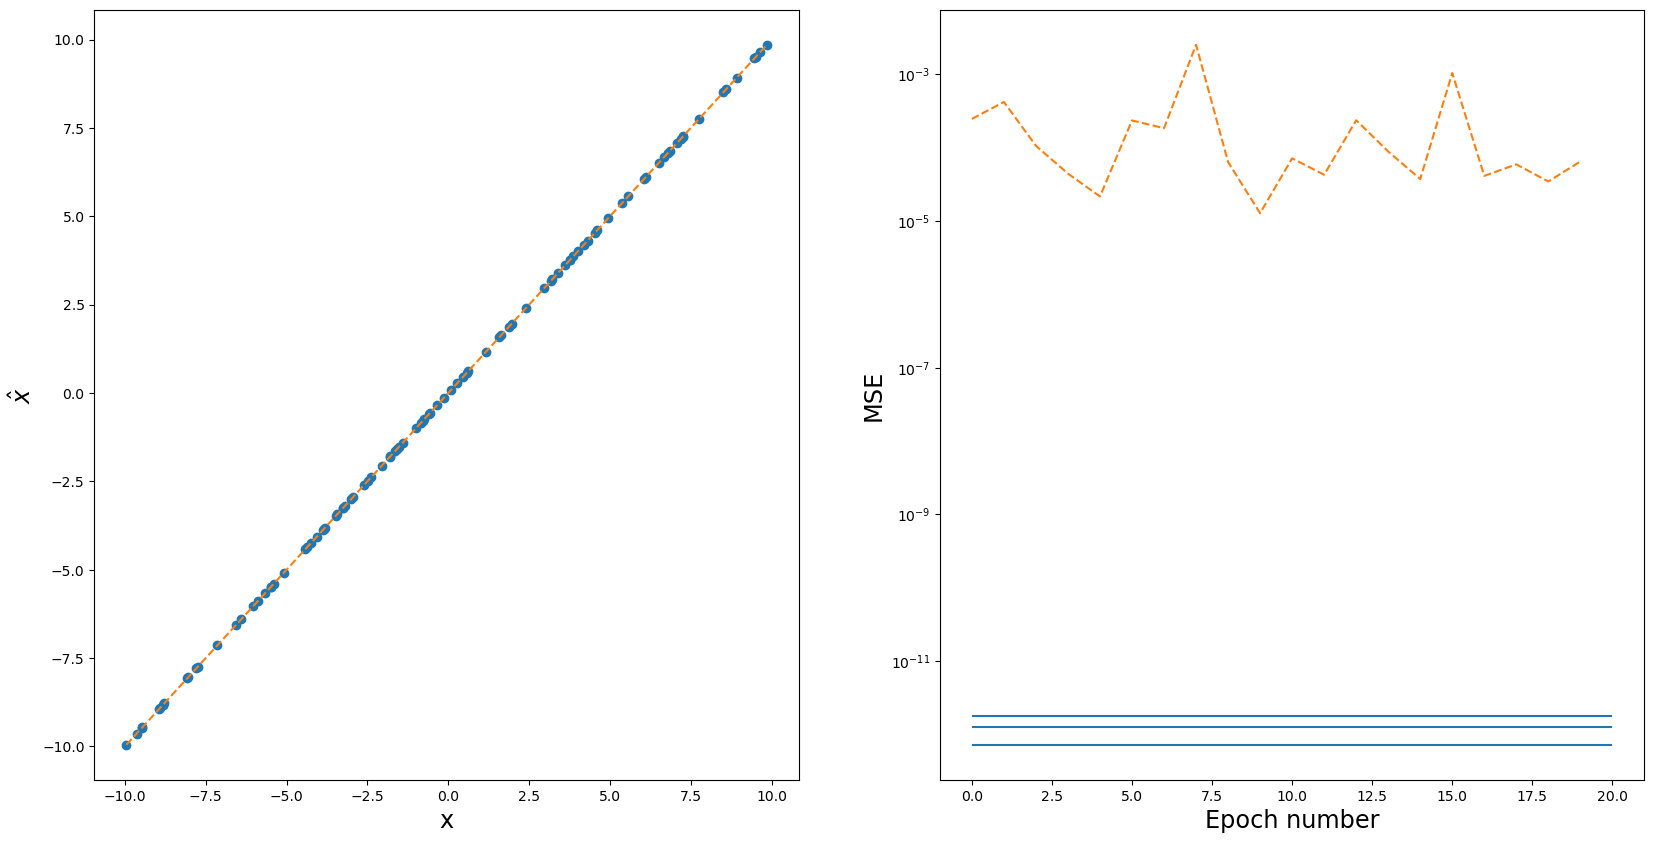

In [22]:
dec_xs = ssp_decoder.decode(enc_ssps)

errors = np.abs(dec_xs - xs)**2
mu_err = np.mean(errors)
ste_err = np.std(errors) / np.sqrt(xs.shape[0])

max_epochs = len(training_history.history['val_loss'])

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(xs, dec_xs)
plt.plot([xs.min(), xs.max()],[xs.min(), xs.max()], ls='--', c='tab:orange')
plt.xlabel('x', fontsize='xx-large')
plt.ylabel(r'$\hat{x}$', fontsize='xx-large')

plt.subplot(1,2,2)
plt.plot(training_history.history['val_loss'], label='Validation loss', ls='--', c='tab:orange')
plt.hlines(y=[mu_err - 1.96 * ste_err, mu_err, mu_err + 1.96 * ste_err], xmin=0, xmax=max_epochs, label='')
plt.yscale('log')
plt.ylabel('MSE', fontsize='xx-large')
plt.xlabel('Epoch number', fontsize='xx-large')
print(mu_err, np.sqrt(mu_err))
print(np.mean(training_history.history['loss']), np.mean(np.sqrt(training_history.history['loss'])))